In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score


In [2]:
base_path = Path('data/')

X_train = np.load(base_path / 'train_images.npy').astype(np.float32)
Y_train = np.load(base_path / 'train_labels.npy')

X_test = np.load(base_path / 'test_public_images.npy').astype(np.float32)
Y_test = np.load(base_path / 'test_public_labels.npy')

classes, counts = np.unique(Y_train, return_counts=True)
counts_test = np.unique(Y_test, return_counts=True)[1]

In [3]:
classes_names = [
    "Avoine d'hiver",
    "Avoine de printemps",
    "Blé tendre d'hiver",
    "Blé tendre de printemps",
    "Colza d'hiver",
    "Luzerne déshydratée",
    "Luzerne",
    "Mélange de légumineuses et graminées",
    "Maïs",
    "Maïs ensilage",
    "Orge d'hiver",
    "Orge de printemps",
    "Prairie permanente - herbe",
    "Prairie permanente - ressources fourragères ligneuses",
    "Prairie en rotation longue",
    "Pomme de terre de consommation",
    "Prairie temporaire",
    "Soja",
    "Tournesol",
    "Triticale d'hiver"
]
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

print(f'Each {X_train.shape[0]} training and {X_test.shape[0]} test samples have :\n'
      f'\t{X_train.shape[1]} images (one per month from Feb to Nov)\n'
      f'\t{X_train.shape[2]} channels (B08 Near Infrared, B04 Red, B03 Green)\n'
      f'\t{X_train.shape[3]} x {X_train.shape[4]} pixels')
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

classes_df = pd.DataFrame({
    'Class Name': classes_names,
    'N Samples in Train': counts,
    'N Samples in Test': counts_test,
    'Frequency in Train': counts / counts.sum(),
    'Frequency in Test': counts_test / counts_test.sum()
},index=classes)

classes_df

Each 10000 training and 2500 test samples have :
	10 images (one per month from Feb to Nov)
	3 channels (B08 Near Infrared, B04 Red, B03 Green)
	32 x 32 pixels
X_train shape: (10000, 10, 3, 32, 32), Y_train shape: (10000,)
X_test shape: (2500, 10, 3, 32, 32), Y_test shape: (2500,)


,Class Name,N Samples in Train,N Samples in Test,Frequency in Train,Frequency in Test
0,Avoine d'hiver,49,11,0.0049,0.0044
1,Avoine de printemps,47,4,0.0047,0.0016
2,Blé tendre d'hiver,2464,781,0.2464,0.3124
3,Blé tendre de printemps,272,108,0.0272,0.0432
4,Colza d'hiver,727,225,0.0727,0.0900
5,Luzerne déshydratée,72,39,0.0072,0.0156
6,Luzerne,267,36,0.0267,0.0144
7,Mélange de légumineuses et graminées,757,84,0.0757,0.0336
8,Maïs,595,116,0.0595,0.0464
9,Maïs ensilage,79,11,0.0079,0.0044


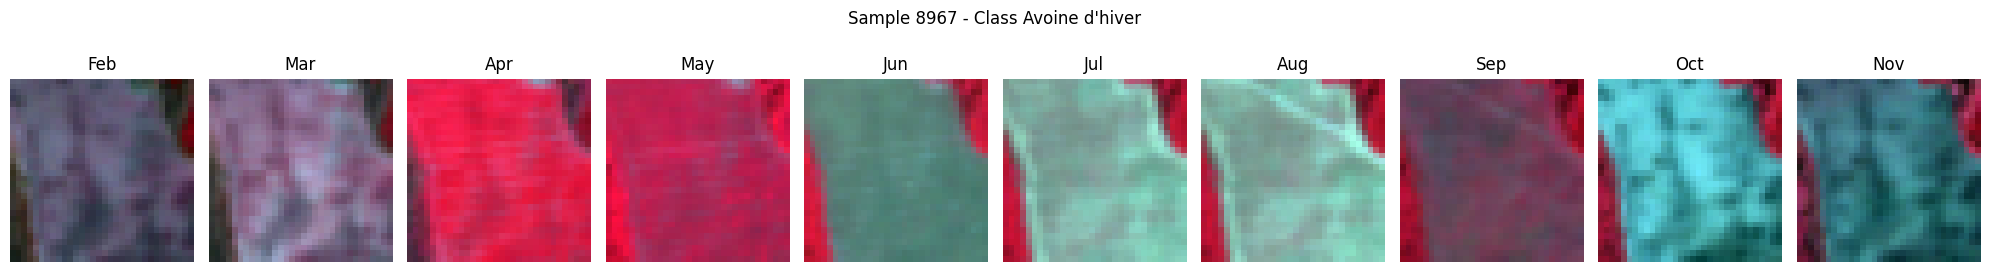

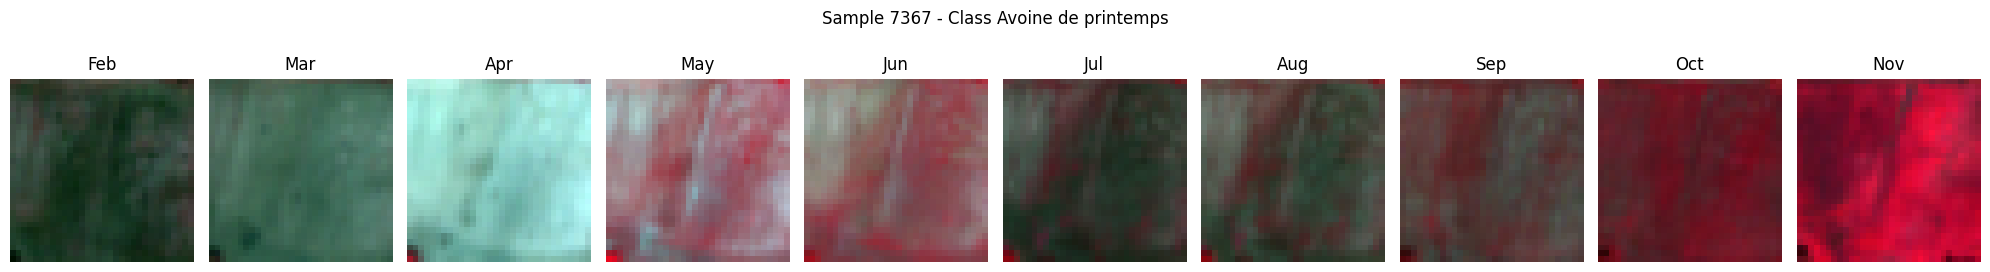

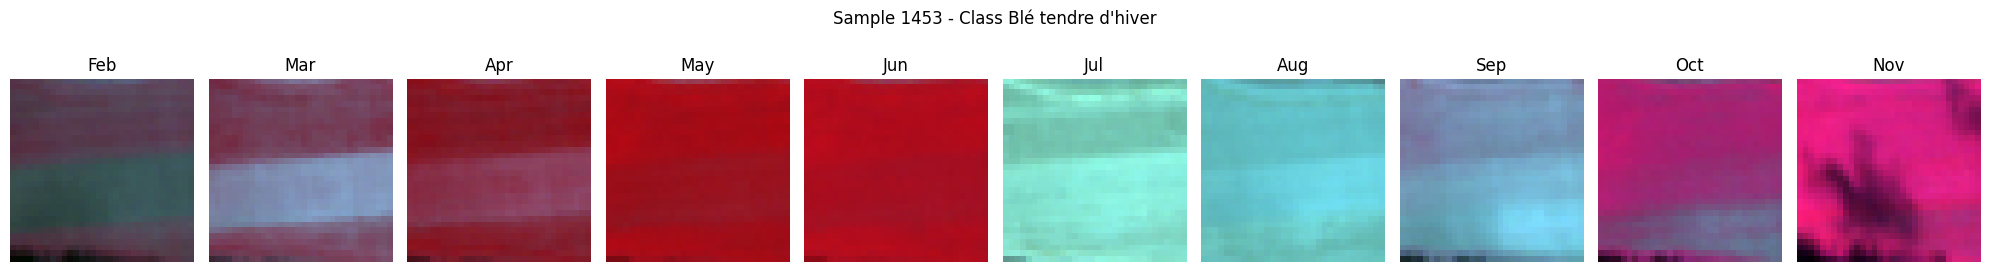

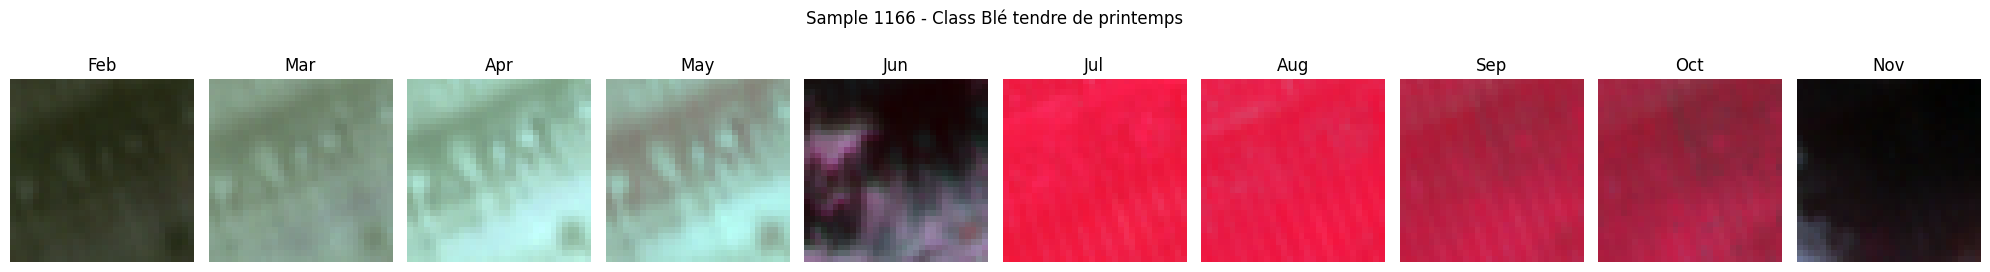

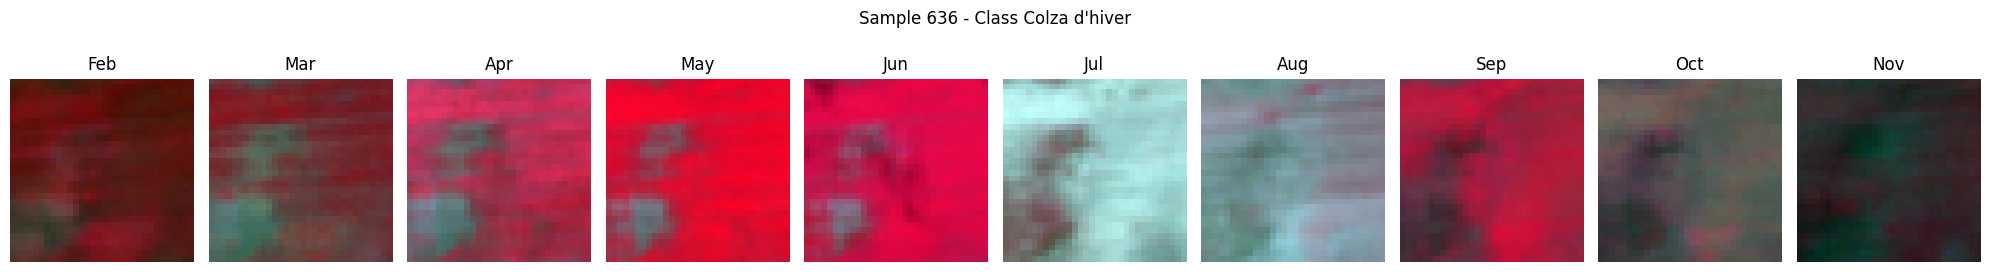

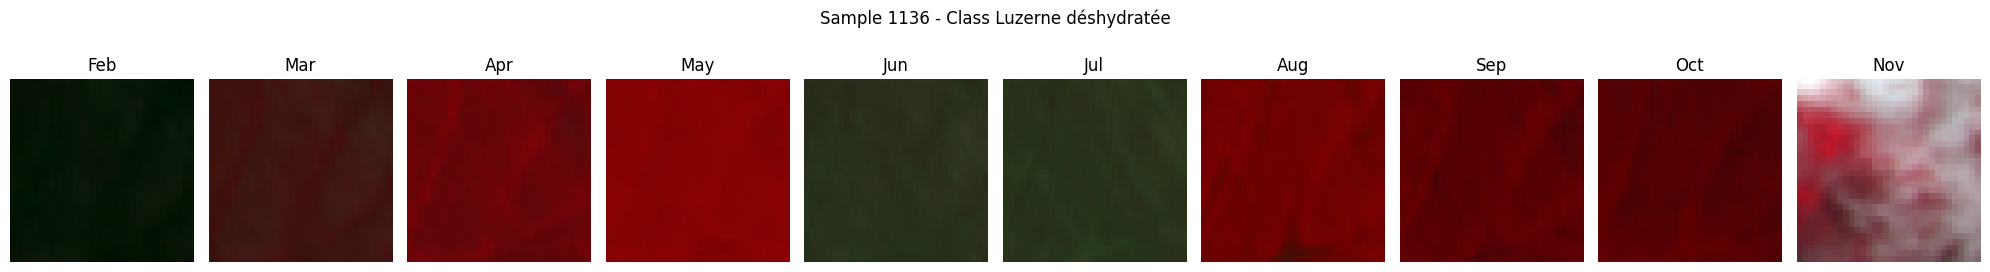

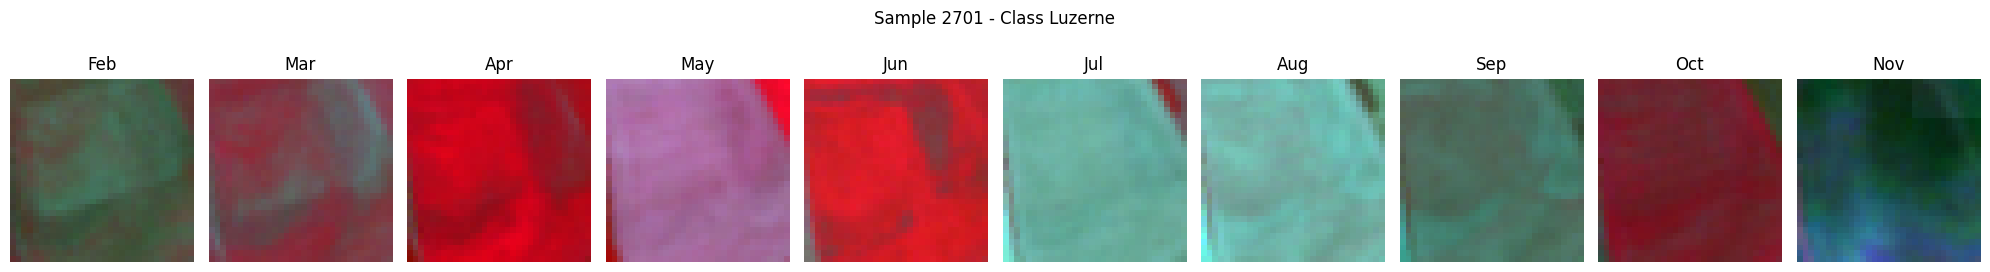

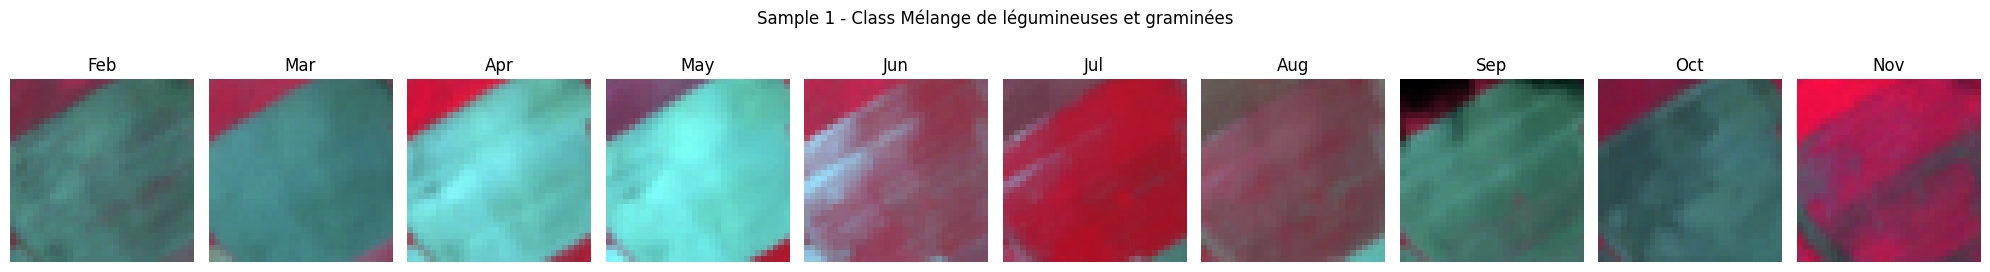

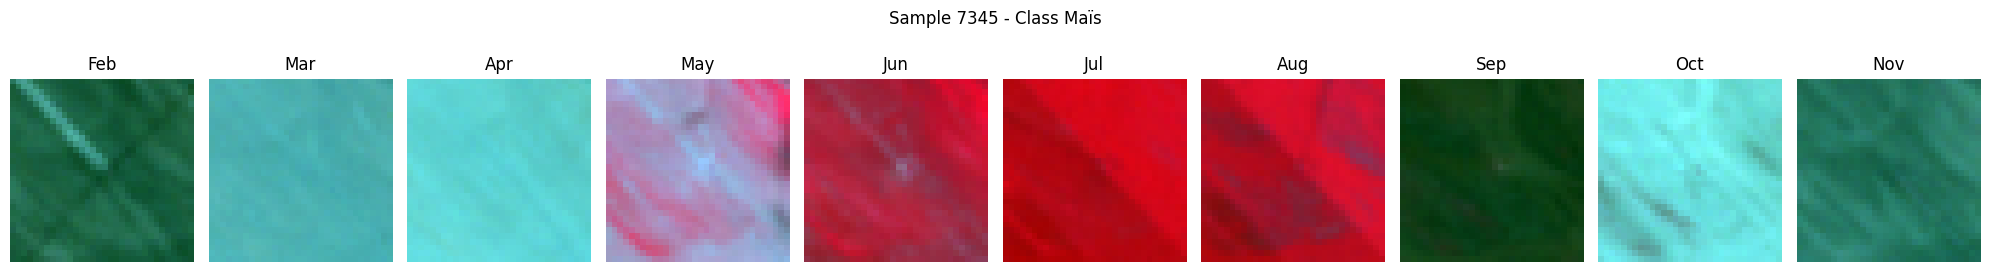

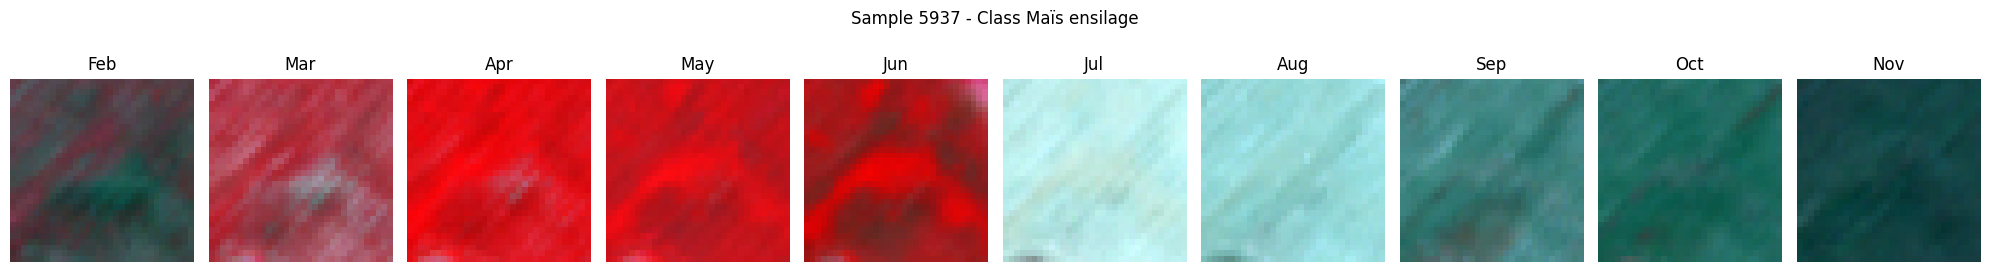

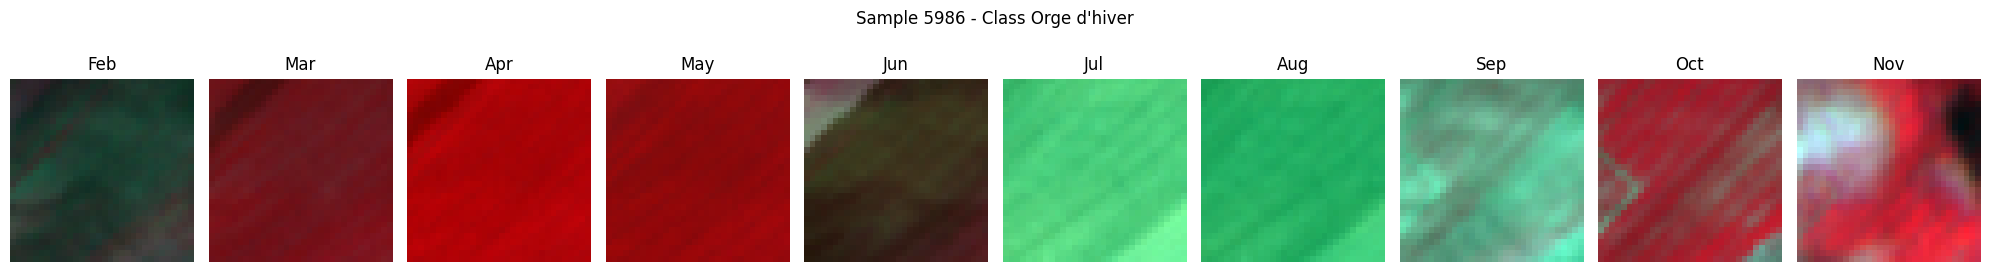

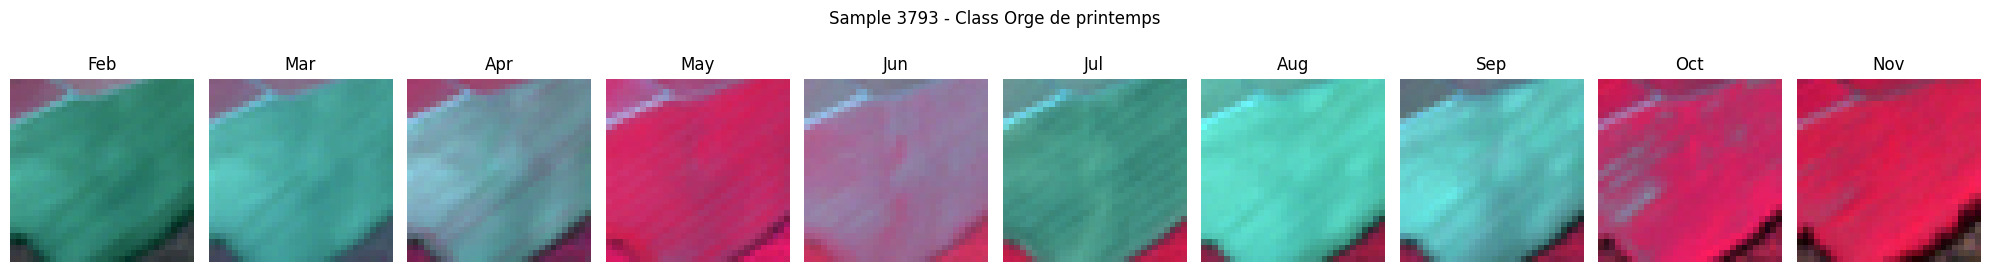

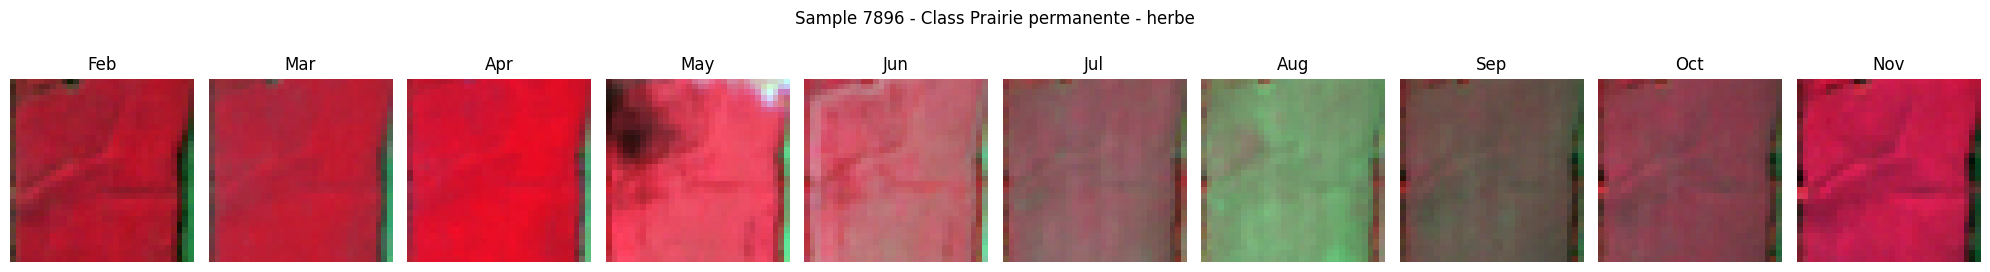

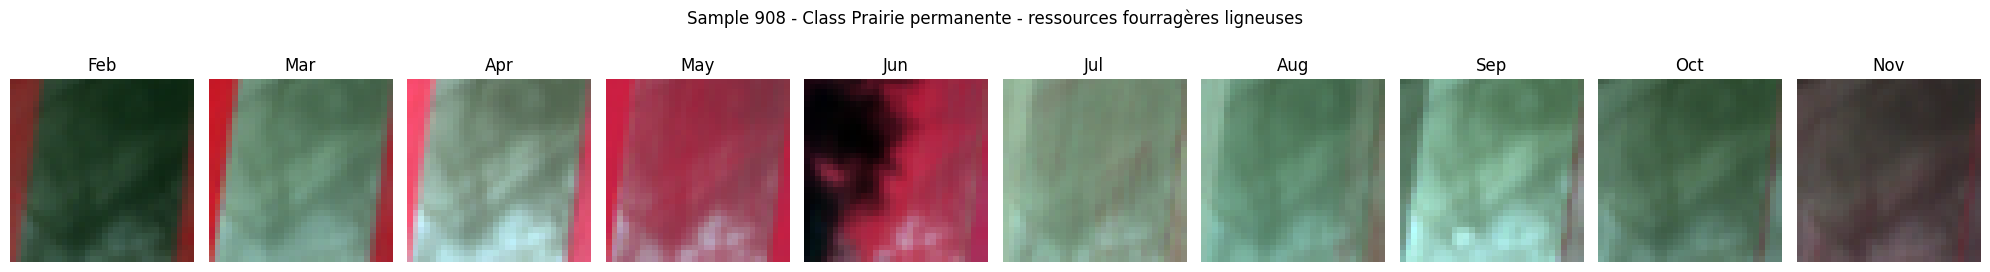

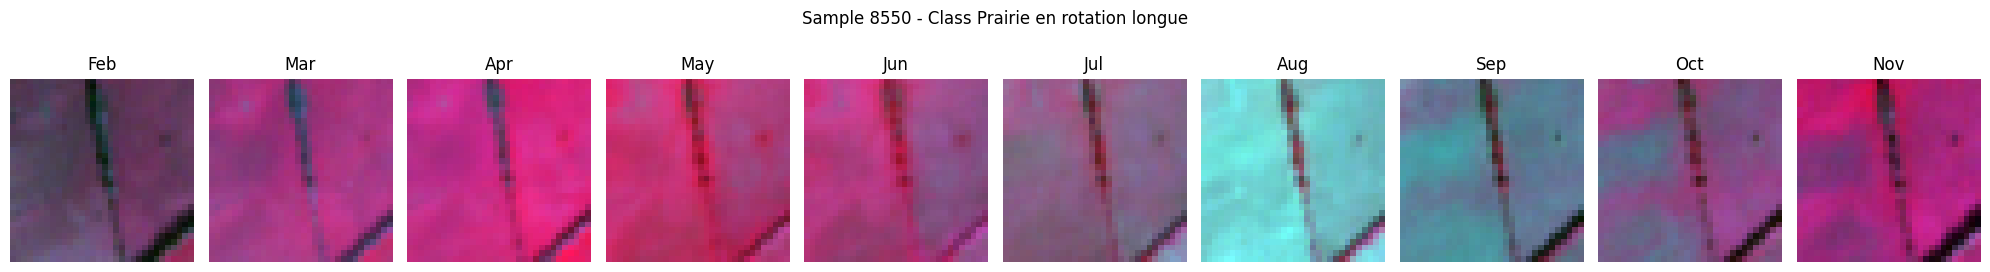

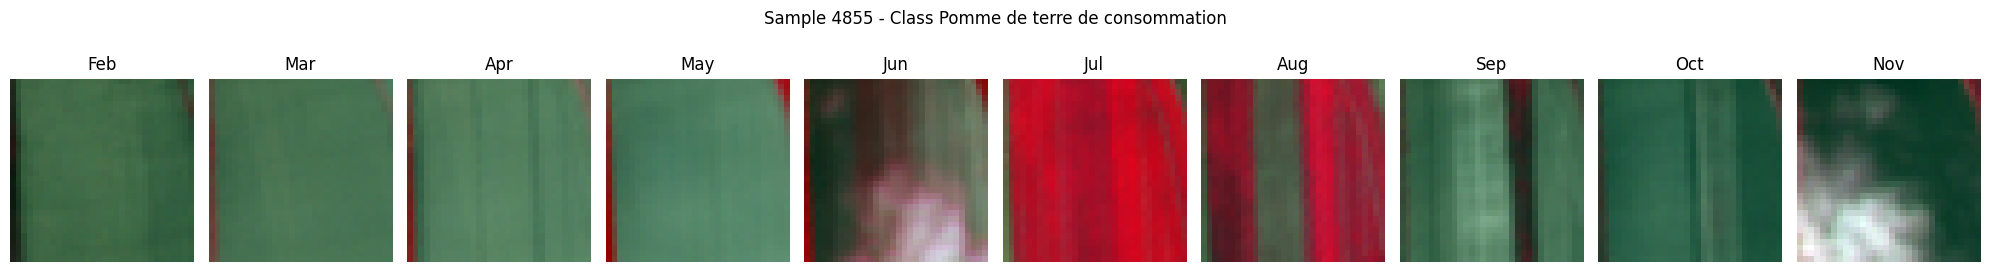

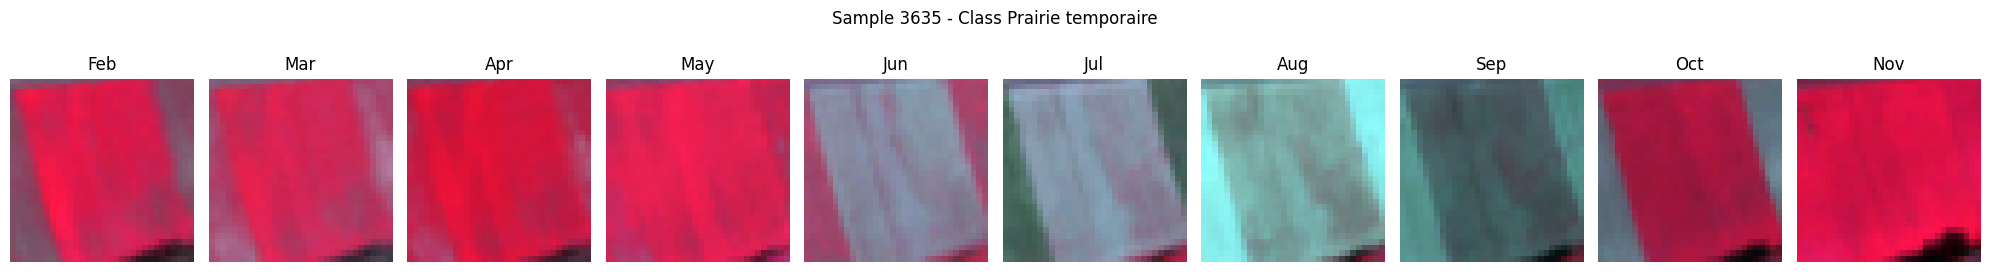

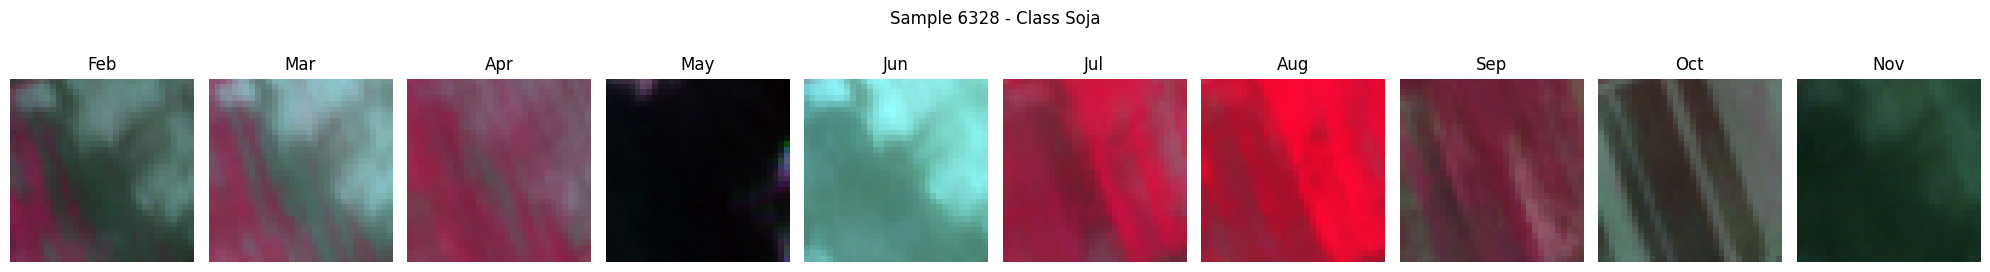

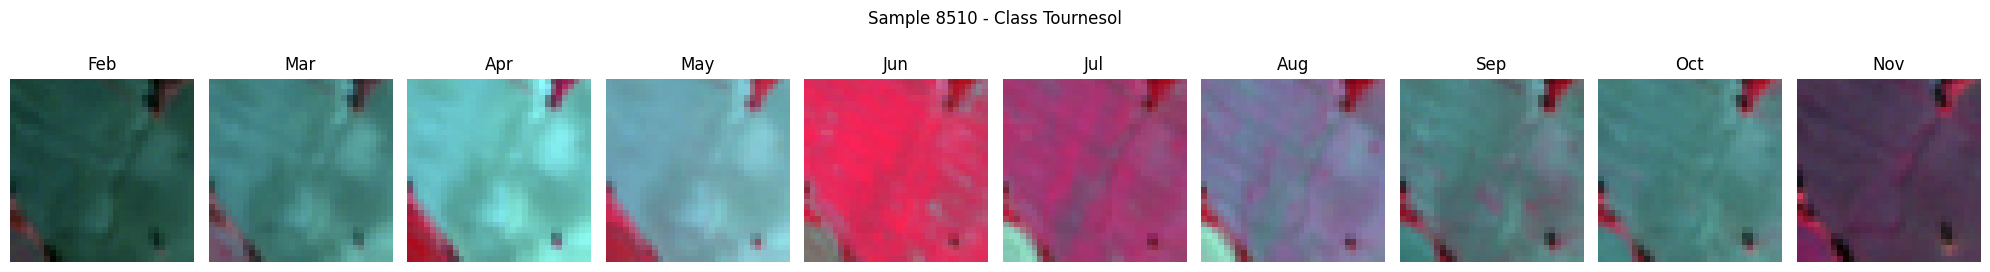

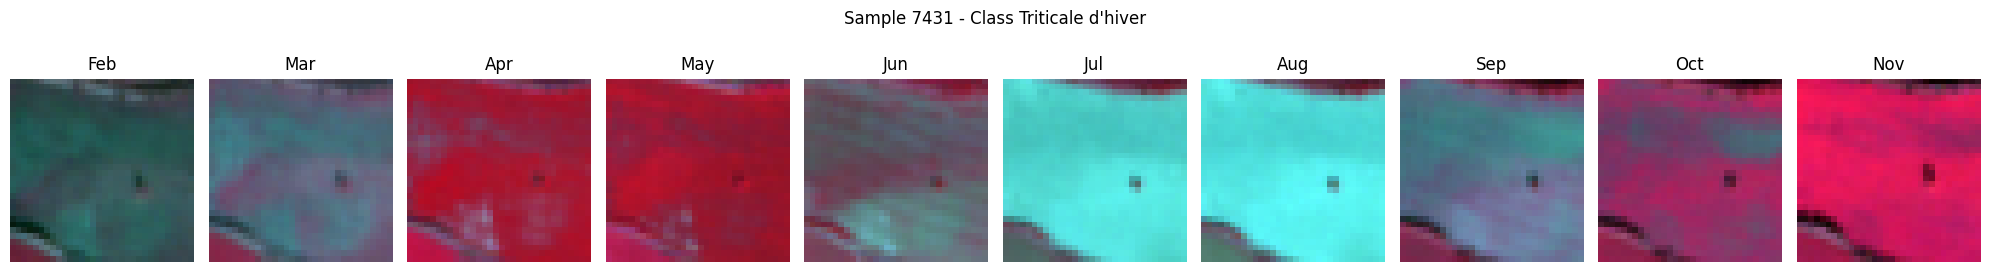

In [4]:
def display_sample(X, Y, sample, grid_shape=(1, 10), size=2):
    x = X[sample].copy()
    y = Y[sample].copy()

    n_rows, n_cols = grid_shape
    n_images = x.shape[0]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size*n_cols, size*n_rows + 1))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    img = x.transpose(0, 2, 3, 1)
    # Normalize each channel independently
    for channel in range(img.shape[-1]):
        img_ch = img[..., channel]
        img_min = img_ch.min()
        img_max = img_ch.max()
        img[..., channel] = (img_ch - img_min) / (img_max - img_min)
    img = img.clip(0, 1)

    for i in range(n_images):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].imshow(img[i])
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{months[i]}')

    # Hide empty subplots if any
    for i in range(n_images, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')

    fig.suptitle(f'Sample {sample} - Class {classes_names[y]}')
    plt.tight_layout()
    plt.show()

def get_random_sample_of_class(X, Y, class_idx):
    """Get a random sample from a specific class"""
    class_indices = np.where(Y == class_idx)[0]
    random_idx = np.random.choice(class_indices)
    return random_idx

for i in [get_random_sample_of_class(X_train, Y_train, i) for i in range(len(classes))]:
    display_sample(X_train, Y_train, i)

## Random Forest Classifier

In [1]:
# Flatten the images to use them in a RandomForestClassifier
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Create a RandomForestClassifier
random_forest = RandomForestClassifier(random_state=0, class_weight="balanced", n_jobs=-1)

NameError: name 'X_train' is not defined

In [6]:
# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [80],
    "min_samples_leaf": [20],
}
# Because the dataset is imbalanced, we use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Use GridSearchCV with k-fold cross-validation to find the best parameters
grid_search = GridSearchCV(
    random_forest,
    param_grid,
    cv=skfold,
    scoring="balanced_accuracy",
    verbose=3,
)

grid_search.fit(X_train_flattened, Y_train)

# Retrieve the best estimator and parameters
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END min_samples_leaf=20, n_estimators=80;, score=0.609 total time=   5.6s
[CV 2/5] END min_samples_leaf=20, n_estimators=80;, score=0.643 total time=   5.7s
[CV 3/5] END min_samples_leaf=20, n_estimators=80;, score=0.605 total time=   5.9s
[CV 4/5] END min_samples_leaf=20, n_estimators=80;, score=0.593 total time=   6.0s
[CV 5/5] END min_samples_leaf=20, n_estimators=80;, score=0.582 total time=   5.9s
Best Parameters: {'min_samples_leaf': 20, 'n_estimators': 80}


In [7]:
# Evaluate the model on the test set
test_predictions = best_rf.predict(X_test_flattened)

test_balanced_accuracy = balanced_accuracy_score(Y_test, test_predictions)
print(f"Test Balanced Accuracy: {100 * test_balanced_accuracy:.2f}%")

print("Classification report on test set:")
print(classification_report(Y_test, test_predictions, target_names=classes_names, zero_division=0))

Test Balanced Accuracy: 50.08%
Classification report on test set:
                                                       precision    recall  f1-score   support

                                       Avoine d'hiver       0.15      0.36      0.21        11
                                  Avoine de printemps       0.00      0.00      0.00         4
                                   Blé tendre d'hiver       0.92      0.40      0.56       781
                              Blé tendre de printemps       0.91      0.97      0.94       108
                                        Colza d'hiver       0.88      0.97      0.92       225
                                  Luzerne déshydratée       0.60      0.74      0.67        39
                                              Luzerne       0.26      0.42      0.32        36
                 Mélange de légumineuses et graminées       0.50      0.43      0.46        84
                                                 Maïs       0.69      0.61    

## Convolutional Neural Network

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
)

# Réorganiser les dimensions pour Conv3D et normaliser les données
X_train_reordered = np.transpose(X_train, (0, 1, 3, 4, 2)) / 255.0 # (batch_size, 10, 32, 32, 3)
X_test_reordered = np.transpose(X_test, (0, 1, 3, 4, 2)) / 255.0   # (batch_size, 10, 32, 32, 3)
input_shape = X_train_reordered.shape[1:]
num_classes = len(classes)

# Construction du modèle CNN 3D
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),
    # Ajouter une couche de convolution supplémentaire
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["Accuracy"])  # Accuracy correspond à SparseCategoricalAccuracy ici

# Résumé du modèle
model.summary()


/home/adrien/Documents/TPS/2A/ClassiField/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 8, 30, 30, 32)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 13, 13, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,204 (2.49 MB)

 Trainable params: 653,204 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
if Path("save/model.h5").exists():
    # Charger le modèle pré-entraîné
    model.load_weights("save/model.h5")
else:
    # Entra1ner le modèle
    history = model.fit(
        X_train_reordered, 
        Y_train,
        validation_split=0.3,
        epochs=10,
        batch_size=32,
        verbose=1
    )
    # Sauvegarder le modèle
    model.save("save/model.h5")

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - Accuracy: 0.7286 - loss: 0.8307 - val_Accuracy: 0.5873 - val_loss: 1.4928
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - Accuracy: 0.7438 - loss: 0.7995 - val_Accuracy: 0.6513 - val_loss: 1.2727
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - Accuracy: 0.7674 - loss: 0.7363 - val_Accuracy: 0.6273 - val_loss: 1.2194
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - Accuracy: 0.7540 - loss: 0.7699 - val_Accuracy: 0.6670 - val_loss: 1.3272
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step - Accuracy: 0.7668 - loss: 0.7302 - val_Accuracy: 0.5620 - val_loss: 1.3862
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - Accuracy: 0.7802 - loss: 0.6933 - val_Accuracy: 0.6107 - val_loss: 1.2262
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - Accuracy: 0.7897 - loss: 0.6505 - val_Accuracy: 0.6637 - val_loss: 1.2327
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - Accuracy: 0.7852 - loss: 0

In [21]:
# Évaluer le modèle avec balanced_accuracy
test_loss, test_accuracy = model.evaluate(X_test_reordered, Y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Balanced Accuracy: {test_accuracy:.4f}")

# Prédire les classes
predictions = model.predict(X_test_reordered)
predicted_classes = np.argmax(predictions, axis=1)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(Y_test, predicted_classes))

Test Loss: 1.1892
Test Balanced Accuracy: 0.6528
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.09      0.10        11
           1       0.00      0.00      0.00         4
           2       0.77      0.79      0.78       781
           3       0.91      0.86      0.89       108
           4       0.81      0.94      0.87       225
           5       0.53      0.44      0.48        39
           6       0.07      0.25      0.11        36
           7       0.38      0.69      0.49        84
           8       0.50      0.46      0.48       116
           9       0.00      0.00      0.00        11
          10       0.54      0.59      0.56       265
          11       0.78      0.71      0.74       235
          12       0.73      0.59      0.65       266
          13       0.26      0.12      0.17        41
          14       0.00      0.00      0.00        40
          15       0.0

/home/adrien/Documents/TPS/2A/ClassiField/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrien/Documents/TPS/2A/ClassiField/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrien/Documents/TPS/2A/ClassiField/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf